# Median Household Income - A Time Series Analysis

Using a time series data set, go about the process of time series modeling. Specifically generate the following things:

1. Plot the time series, along with any logical or necessary differences to get a stationary dataset
2. Generate and interpret a PACF for the time series (and/or its differences)
3. Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
4. Finally choose one specification and make the case for that as a logical model for your dataset.

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA

For this challenge I have taken the [Real Median Household Income in the United States](https://fred.stlouisfed.org/series/MEHOINUSA672N) data set from the FRED website. The data ranges all the way back to 1984 and provides us with an annual value for the median income for households in the US. Let's begin by taking a look at what the data looks like.

In [2]:
# Read in the CSV
salary_df = pd.read_csv("Median-House-Data-US-Census.csv")

# Rename the columns
salary_df.columns = ['DATE', 'MED_SALARY']

# Print out the first few rows
salary_df.head()

,DATE,MED_SALARY
0,1984-01-01,51742
1,1985-01-01,52709
2,1986-01-01,54608
3,1987-01-01,55260
4,1988-01-01,55716


### 1. Plot the time series, along with any logical or necessary differences to get a stationary dataset

First, in order to get a readable plot, we'll have to assign the Dates to the index and put them in datetime format with pandas. Then we can check out what the salaries look like over time using a regular plot.

Text(0, 0.5, 'Salary in USD')

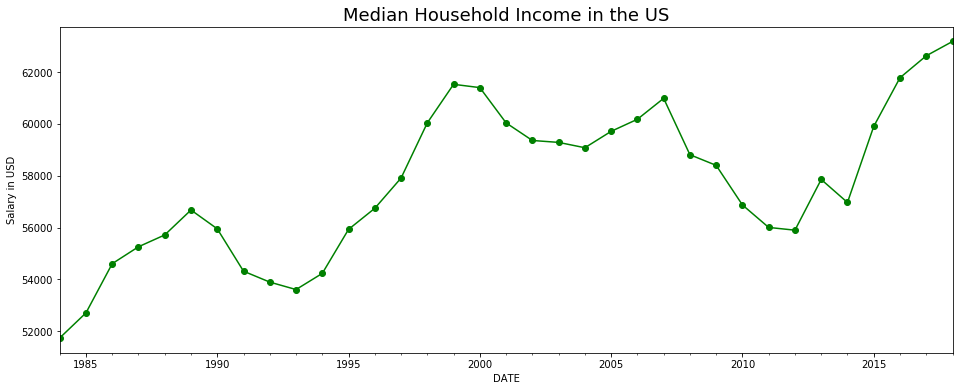

In [3]:
# Change the index to be the dates from the data formatted to datetime
salary_df.index = pd.to_datetime(salary_df.DATE)

# Plot the median salaries of all years
plt.rcParams['figure.figsize'] = [16, 6]
salary_df.MED_SALARY.plot(linestyle='-', marker='o', color='g')
plt.title('Median Household Income in the US', fontsize='18')
plt.ylabel('Salary in USD')

Looks pretty good, but it seems we have a bit of a linear trend upwards over this span of time, so this isn't a stationary data set just yet. Let's go ahead and plot the differences between the median income of each year instead.

Text(0.5, 1.0, 'Difference in Median Household Income in the US Each Year')

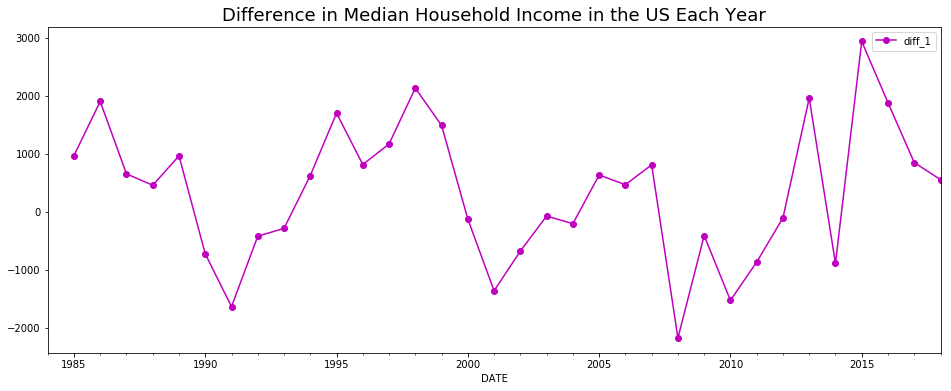

In [4]:
# Create a new column that holds the differences between each year
salary_df['diff_1'] = salary_df.MED_SALARY - salary_df.MED_SALARY.shift()

# Plot this new value
plt.rcParams['figure.figsize'] = [16, 6]
salary_df.plot(y='diff_1', linestyle='-', marker='o', color='m')
plt.title('Difference in Median Household Income in the US Each Year', fontsize='18')

Now we can see that this is a stationary dataset as it fluctuates around a centered horizontal line instead of trending upwards or downwards.

### 2. Generate and interpret a PACF for the time series (and/or its differences)

Following this, let's look at what the PACF looks like for both the original data set and the difference between years data set.

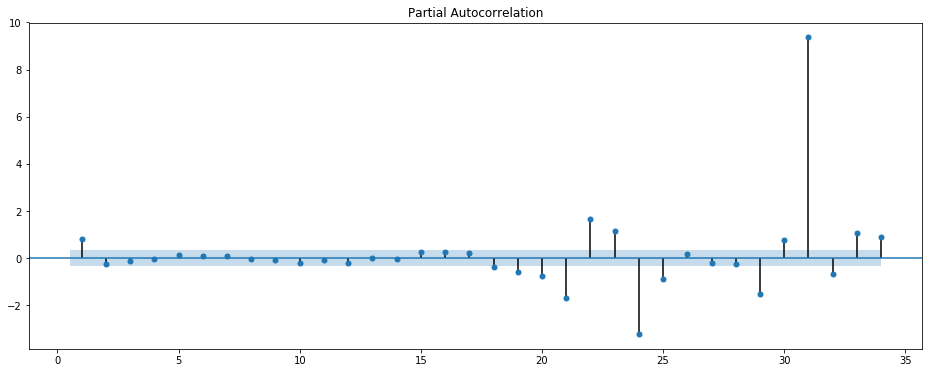

In [12]:
# Create the PACF dataframe from our original data
plt.rcParams['figure.figsize'] = [16, 6]
reg_pacf = plot_pacf(salary_df.MED_SALARY, lags=35, zero=False)

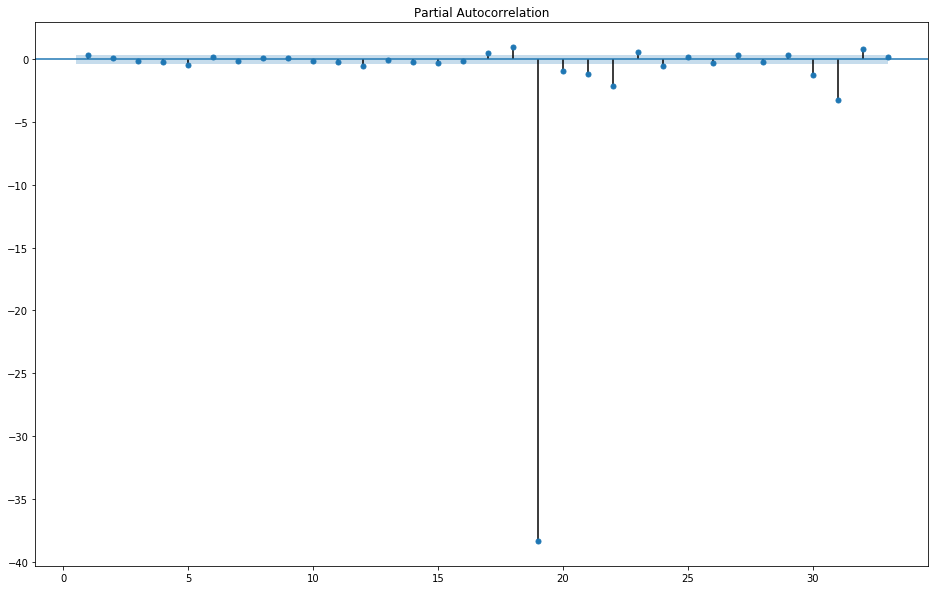

In [6]:
# Create our plot for the PACF of the difference in salaries
# Don't include the first value because it contains a NaN
plt.rcParams['figure.figsize'] = [16, 10]
diff_pacf = plot_pacf(salary_df['diff_1'][1:], lags=34, zero=False)

It looks like the 31st lag is heavily correlated for the data before taking the difference, and the 19th lag is extremely correlated when the differences are taken into account.

### 3. Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data

First let's compare between the standard ARIMA(1,1,1) model for the regular median salary and the differences in the salaries to determine which direction we will want to go with the following models.

In [7]:
model_1 = ARIMA(salary_df.MED_SALARY, order=(1,1,1), freq=salary_df.index.inferred_freq)
model_1_fit = model_1.fit()
print(model_1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.MED_SALARY   No. Observations:                   34
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -286.427
Method:                       css-mle   S.D. of innovations           1100.401
Date:                Wed, 09 Oct 2019   AIC                            580.853
Time:                        22:06:25   BIC                            586.959
Sample:                    01-01-1985   HQIC                           582.935
                         - 01-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                358.7915    302.685      1.185      0.245    -234.461     952.044
ar.L1.D.MED_SALARY     0.4882      0.289      1.687      0.102      -0.079       1.055
ma.L1.D.MED_SALARY  

In [8]:
model_2 = ARIMA(salary_df['diff_1'][1:], order=(1,1,1), freq=salary_df.index.inferred_freq)
model_2_fit = model_2.fit()
print(model_2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.diff_1   No. Observations:                   33
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -279.952
Method:                       css-mle   S.D. of innovations           1121.623
Date:                Wed, 09 Oct 2019   AIC                            567.905
Time:                        22:06:26   BIC                            573.891
Sample:                    01-01-1986   HQIC                           569.919
                         - 01-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.4752     29.878     -0.116      0.908     -62.036      55.085
ar.L1.D.diff_1     0.3771      0.166      2.270      0.031       0.052       0.703
ma.L1.D.diff_1    -1.0000      0.091

Seems that the differences between salaries over the years performed better, which isn't all that surprising. We can see this because we have a lower AIC, standard error, and a tighter confidence interval. Let's also look how well the differences between salaries does when we look at it with different values for AR, MA, and I.

In [9]:
model_3 = ARIMA(salary_df['diff_1'][1:], order=(6,0,0), freq=salary_df.index.inferred_freq)
model_3_fit = model_3.fit()
print(model_3_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 diff_1   No. Observations:                   34
Model:                     ARMA(6, 0)   Log Likelihood                -280.950
Method:                       css-mle   S.D. of innovations            908.437
Date:                Wed, 09 Oct 2019   AIC                            577.900
Time:                        22:06:26   BIC                            590.111
Sample:                    01-01-1985   HQIC                           582.064
                         - 01-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          269.2101    173.372      1.553      0.132     -70.594     609.014
ar.L1.diff_1     0.2638      0.169      1.565      0.129      -0.067       0.594
ar.L2.diff_1     0.1731      0.148      1.17

In [16]:
model_4 = ARIMA(salary_df['diff_1'][1:], order=(0,0,4), freq=salary_df.index.inferred_freq)
model_4_fit = model_4.fit()
print(model_4_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 diff_1   No. Observations:                   34
Model:                     ARMA(0, 4)   Log Likelihood                -285.030
Method:                       css-mle   S.D. of innovations           1045.823
Date:                Wed, 09 Oct 2019   AIC                            582.059
Time:                        22:07:05   BIC                            591.218
Sample:                    01-01-1985   HQIC                           585.183
                         - 01-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          363.4401    430.386      0.844      0.405    -480.101    1206.981
ma.L1.diff_1     0.4236      0.237      1.785      0.085      -0.042       0.889
ma.L2.diff_1     0.3812      0.175      2.18

In [11]:
model_5 = ARIMA(salary_df['diff_1'][1:], order=(1,0,1), freq=salary_df.index.inferred_freq)
model_5_fit = model_5.fit()
print(model_5_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 diff_1   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                -286.427
Method:                       css-mle   S.D. of innovations           1100.401
Date:                Wed, 09 Oct 2019   AIC                            580.853
Time:                        22:06:27   BIC                            586.959
Sample:                    01-01-1985   HQIC                           582.935
                         - 01-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          358.7915    302.685      1.185      0.245    -234.461     952.044
ar.L1.diff_1     0.4882      0.289      1.687      0.102      -0.079       1.055
ma.L1.diff_1    -0.1644      0.300     -0.54

### 4. Finally choose one specification and make the case for that as a logical model for your dataset.

Clearly, the ARIMA(1,1,1) model takes the gold in this analysis. None of the others performed as well when it came to AIC, standard error, or the confidence intervals. Therefore, I would stick with that model going forward in making predictions of future median income values.